In [161]:
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
from itables import show
from sklearn.linear_model import LinearRegression

## Clean dataset
> 1. Filter for only total electric power industry
> 2. Filter out "Total" energy produced rows
> 3. Identify renewable energy sources
> 4. Aggregate data by year, state, and renewable boolean

In [162]:
# Load the data from csv file
data = pd.read_csv('Data/annual_generation_state.csv', thousands=',')
data.rename(columns={'YEAR': 'year', 'STATE': 'state', 'TYPE OF PRODUCER': 'producer', 'ENERGY SOURCE': 'source', 'GENERATION (Megawatthours)': 'generation'}, inplace=True)

# Change all strings to upper for consistency (state column has 'US-Total' and 'US-TOTAL')
data['state'] = data['state'].str.upper()
data['producer'] = data['producer'].str.upper()
data['source'] = data['source'].str.upper()

# Filter data 
data = data[data['source'] != 'TOTAL']
data =  data[data['state'] != 'US-TOTAL']
data = data[data['producer'] == 'TOTAL ELECTRIC POWER INDUSTRY']

# Remove the blank state rows (3 rows for 2003 with 0 generation in coal, natural gas, and petroleum)
data = data[data['state'] != '  ']

# Created is_renewable boolean column
renewables = ['HYDROELECTRIC CONVENTIONAL', 'WIND', 'WOOD AND WOOD DERIVED FUELS', 'OTHER BIOMASS', 'GEOTHERMAL', 'SOLAR THERMAL AND PHOTOVOLTAIC']
data['is_renewable'] = data['source'].isin(renewables)

# Create a new dataframe with the aggregated data
agg_data = data.groupby(['year', 'state', 'is_renewable'])['generation'].sum().reset_index()


## Tables of electricity generation using renewables

In [172]:
# Show the basic data (with generation in megawatthours)
show(agg_data)

In [164]:
# Show normalized data (percentage of total energy being produced with renewables)\
total_energy = agg_data.groupby(['year', 'state'])['generation'].sum().reset_index()
total_energy.rename(columns={'generation': 'total_generation'}, inplace=True)
normalized_data = agg_data[agg_data['is_renewable']].merge(total_energy, on=['year', 'state'], how='outer').fillna(0)
normalized_data['renewable_pct'] = (normalized_data['generation'] / normalized_data['total_generation'])
normalized_data.drop(columns=['is_renewable'], inplace=True)

show(normalized_data)

In [165]:
# Find diff between 2021 and 1990 levels of renewable energy percentage
filtered_data = normalized_data[normalized_data['year'].isin([1990, 2021])]
filtered_data = filtered_data.pivot(index='state', columns='year', values='renewable_pct')

filtered_data['difference (2021-1990)'] = filtered_data[2021] - filtered_data[1990]

show(filtered_data)

## Time Series Analyses (raw output in megawatthours)

Linear regression for CA:
Slope: 912398.0656158361
Intercept: -1766108544.4050593
R^2: 0.384343850192296


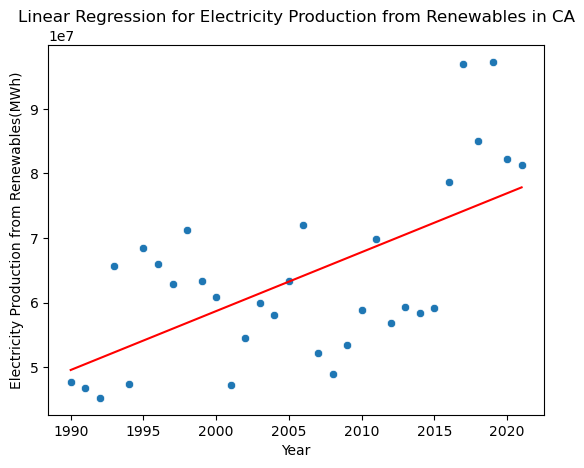

In [166]:
# Choose a state for analysis
state = 'CA'

# Run basic linear regression
state_data = agg_data[(agg_data['state'] == state) & (agg_data['is_renewable'])]
X = state_data['year'].values.reshape(-1, 1)
y = state_data['generation'].values
model = LinearRegression().fit(X, y)
slope = model.coef_[0]
intercept = model.intercept_
r_squared = model.score(X, y)
print(f'Linear regression for {state}:\nSlope: {slope}\nIntercept: {intercept}\nR^2: {r_squared}')

# Plot the results
sns.scatterplot(x='year', y='generation', data=state_data)
plt.plot(X, model.predict(X), label='Predicted Electricity Production', color='red')
plt.title(f'Linear Regression for Electricity Production from Renewables in {state}')
plt.xlabel('Year')
plt.ylabel('Electricity Production from Renewables(MWh)')
plt.show()

## Time Series Analysis (percentage from renewables)

Linear regression for CA:
Slope: 0.0031442094524223186
Intercept: -5.97650299671932
R^2: 0.19617808438875173


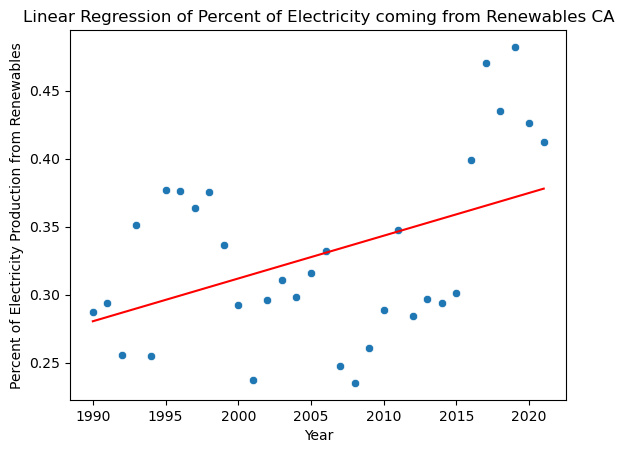

In [167]:
# Choose a state for analysis
state = 'CA'

# Run basic linear regression
state_data = normalized_data[normalized_data['state'] == state]
X = state_data['year'].values.reshape(-1, 1)
y = state_data['renewable_pct'].values
model = LinearRegression().fit(X, y)
slope = model.coef_[0]
intercept = model.intercept_
r_squared = model.score(X, y)
print(f'Linear regression for {state}:\nSlope: {slope}\nIntercept: {intercept}\nR^2: {r_squared}')

# Plot the results
sns.scatterplot(x='year', y='renewable_pct', data=state_data)
plt.plot(X, model.predict(X), label='Predicted Electricity Production', color='red')
plt.title(f'Linear Regression of Percent of Electricity coming from Renewables {state}')
plt.xlabel('Year')
plt.ylabel('Percent of Electricity Production from Renewables')
plt.show()

## Compare Time Series Analyses for every state (raw output in megawatthours)

In [168]:
results = {}
for state in agg_data['state'].unique():
    # Run basic linear regression
    state_data = agg_data[(agg_data['state'] == state) & (agg_data['is_renewable'])]
    X = state_data['year'].values.reshape(-1, 1)
    y = state_data['generation'].values
    model = LinearRegression().fit(X, y)
    slope = model.coef_[0]
    intercept = model.intercept_
    r_squared = model.score(X, y)
    results[state] = {'slope': slope, 'intercept': intercept, 'r_squared': r_squared}

results_df = pd.DataFrame.from_dict(results, orient='index')
show(results_df)

## Compare Time Series Analyses for every state (percentage from renewables)

In [169]:
# Run time series regression on each state and save results
results = {}
for state in normalized_data['state'].unique():
    # Run basic linear regression
    state_data = normalized_data[normalized_data['state'] == state]
    X = state_data['year'].values.reshape(-1, 1)
    y = state_data['renewable_pct'].values
    model = LinearRegression().fit(X, y)
    slope = model.coef_[0]
    intercept = model.intercept_
    r_squared = model.score(X, y)
    results[state] = {'slope': slope, 'intercept': intercept, 'r_squared': r_squared}

results_df = pd.DataFrame.from_dict(results, orient='index')
show(results_df)

## Fixed Effects Model

In [170]:
X_dummies = pd.get_dummies(normalized_data['state'], drop_first=True)
X = pd.concat([normalized_data['year'], X_dummies], axis=1)
X = sm.add_constant(X)
y = normalized_data['renewable_pct']
normalized_model = sm.OLS(y, X).fit()
normalized_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          renewable_pct   R-squared:                       0.883
Model:                            OLS   Adj. R-squared:                  0.880
Method:                 Least Squares   F-statistic:                     234.8
Date:                Sat, 19 Aug 2023   Prob (F-statistic):               0.00
Time:                        17:05:39   Log-Likelihood:                 1894.4
No. Observations:                1632   AIC:                            -3685.
Df Residuals:                    1580   BIC:                            -3404.
Df Model:                          51                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -6.1335      0.414    -14.801      0.000      -6.946      -5.321
year           0.0032      0.000     15.363      0.000       0.003       0.004
AL            -0.1262      0.019     -6.552      0.000      -0.164      -0.088
AR            -0.1343      0.019     -6.973      0.000      -0.172      -0.097
AZ            -0.1335      0.019     -6.934      0.000      -0.171      -0.096
CA             0.0996      0.019      5.172      0.000       0.062       0.137
CO            -0.1206      0.019     -6.261      0.000      -0.158      -0.083
CT            -0.1773      0.019     -9.207      0.000      -0.215      -0.140
DC            -0.1128      0.019     -5.855      0.000      -0.151      -0.075
DE            -0.2204      0.019    -11.443      0.000      -0.258      -0.183
FL            -0.2014      0.019    -10.458      0.000      -0.239      -0.164
GA            -0.1644      0.019     -8.537      0.000      -0.202      -0.127
HI            -0.1318      0.019     -6.845      0.000      -0.170      -0.094
IA            -0.0637      0.019     -3.310      0.001      -0.102      -0.026
ID             0.6469      0.019     33.590      0.000       0.609       0.685
IL            -0.2025      0.019    -10.513      0.000      -0.240      -0.165
IN            -0.2056      0.019    -10.675      0.000      -0.243      -0.168
KS            -0.1213      0.019     -6.296      0.000      -0.159      -0.083
KY            -0.1863      0.019     -9.673      0.000      -0.224      -0.148
LA            -0.1900      0.019     -9.865      0.000      -0.228      -0.152
MA            -0.1493      0.019     -7.751      0.000      -0.187      -0.111
MD            -0.1668      0.019     -8.660      0.000      -0.205      -0.129
ME             0.3200      0.019     16.616      0.000       0.282       0.358
MI            -0.1795      0.019     -9.318      0.000      -0.217      -0.142
MN            -0.1078      0.019     -5.600      0.000      -0.146      -0.070
MO            -0.1991      0.019    -10.339      0.000      -0.237      -0.161
MS            -0.1910      0.019     -9.920      0.000      -0.229      -0.153
MT             0.1800      0.019      9.346      0.000       0.142       0.218
NC            -0.1579      0.019     -8.198      0.000      -0.196      -0.120
ND            -0.0802      0.019     -4.166      0.000      -0.118      -0.042
NE            -0.1455      0.019     -7.553      0.000      -0.183      -0.108
NH            -0.0765      0.019     -3.975      0.000      -0.114      -0.039
NJ            -0.2087      0.019    -10.837      0.000      -0.246      -0.171
NM            -0.1602      0.019     -8.317      0.000      -0.198      -0.122
NV            -0.0736      0.019     -3.821      0.000      -0.111      -0.036
NY            -0.0014      0.019     -0.074      0.941      -0.039       0.036
OH